<a href="https://colab.research.google.com/github/Kusakawama/MADS_CNN/blob/main/ML_cleaned_ResNetTexts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automatische Erkennung von Musikinstrumenten
**Gruppe:** Grumpy

# Importe
Im Folgenden werden zunächst alle benötigten Libarys importiert, die für dieses Notebook notwendig sind.


In [ ]:
! pip install keras-cv tensorflow --upgrade
! pip install keras_core

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.1/803.1 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 924.6/924.6 kB 29.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as sk
import tensorflow as tf
from glob import glob
import cv2
import json
from keras.models import load_model
import keras_cv
from tensorflow.keras.utils import plot_model
from IPython.display import Image
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
#from keras.utils import to_categorical
#from keras.src.layers.preprocessing.normalization import Normalization

Using TensorFlow backend


# Use Case

Ein Second-Hand Retailer für Musikinstrumente betreibt seit einiger Zeit eine eigene E-Commerce Plattform. Das Unternehmen ermöglicht Musik-Interessierten über Ihre Plattform den Handel mit gebrauchten Instrumenten. Im Fokus steht dabei besonders die Gestaltung eines unkomplizierten Kauf- und Verkauf-Prozesses.

Um ein Instrument zu verkaufen, erstellt der Verkäufer eine Anzeige mit folgenden Informationen: Anzeigen-Titel, Preis, Instrumenten-Kategorie und Bilder des gebrauchten Instruments. Dabei müssen die Instrumenten-Kategorien manuell aus einer Liste durch den Verkäufer ausgewählt werden. Beim Kauf hingegen haben die Nutzer der Plattform verschiedene Möglichkeiten: Neben der Suche nach Anzeigen-Titeln kann auch nach Instrumenten-Kategorien gefiltert werden.

Die manuelle Auswahl von Instrumenten-Kategorien birgt eine hohe Fehleranfälligkeit und führt dazu, dass Verkäufer regelmäßig falsche Kategorien auswählen. Dadurch werden potenziellen Käufern im Kauf-Prozess Produkte aus falschen Kategorien vorgeschlagen und Produkte aus richtigen Kategorien vorenthalten. Anzeigen verweilen so länger als nötig auf der Plattform und sowohl kaufende wie auch verkaufende Kunden haben ein negatives Erlebnis. Aktuell kann diesem Problem nicht durch den Second-Hand Retailer entgegengewirkt werden, da die manuelle Korrektur nur durch einen sehr hohen Ressourcenaufwand, und damit verbunden sehr hohen Kosten, möglich wäre. Zudem wäre dieser Lösungsansatz nur temporär.

Um diese Herausforderung zu bewältigen und die Qualität der eigenen Plattform zu steigern, heuert der Second-Hand Retailer ein Team von Machine Learning Experten an. Dieses Team soll ein Modell entwickeln, das in der Lage ist, die von den Verkäufern hochgeladenen Bilder zu analysieren und automatisch die richtige Kategorie für die Anzeige zu setzen. Diese Automatisierung verspricht eine Steigerung der Effizienz sowie eine Verbesserung der Prozess-Genauigkeit.

# Der Datensatz

Dieser Abschnitt beinhaltet alle den Datensatz betreffenden Grundlagen. Hierzu gehören:
* der Hintergrund des Datensatzes,
* der Datenimport,
* das Definieren der Trainings-, Test- und Validierungsdatensätze,
* sowie die Datenexploration.

## Hintergrund

Der für dieses Projekt verwendete Datensatz "30 Musical Instruments - Image Classification" (https://www.kaggle.com/datasets/gpiosenka/musical-instruments-image-classification?select=instruments.csv) stammt von Kaggle.com.

Die Bilder wurden von Gerry (https://www.kaggle.com/gpiosenka) bereitgestellt und stammen aus einer strukturierten Internetrecherche.

Die Struktur der Daten kann auf Kaggle eingesehen werden und spielte eine entscheidende Rolle bei der Auswahl der Daten. Genauer stand für dieses Projekt die Verwendbarkeit im Fokus. Hier war eine Mindestanzahl an Bildern in geeigneter Struktur erforderlich.

Die Bilddaten sind nach Klassen in Ordner mit dem jeweiligen Namen strukturiert, was mit dem erforderlichen Input-Format der "image_dataset_from_directory"-Funktion von Keras (https://keras.io/api/data_loading/image/) übereinstimmt.

Zusätzlich ist die Menge der Daten mit 5093 Bildern zwar ausbaufähig, für die Zwecke dieses Projektes jedoch ausreichend.

Schließlich sprach auch die Vorverarbeitung für diesen Datensatz. Die Bilder wurden bereits auf Duplikate geprüft und in das einheitliche Format von 224 x 224 RGB gebracht, sodass diese Schritte bei der Vorverarbeitung eingespart werden können.

## Datenimport



Zunächst müssen die Daten aus Kaggle geladen werden. Hierfür wird die Kaggle API verwendet.

Für eine leichtere Kollaboration wird der private Kaggle-Token hard-codet in der Variable `json_token` gespeichert und in die Colab-Umgebung geladen.

Im Anschluss wird die Funktion `import_data()` definiert. Diese bildet alle notwendigen Schritte ab, um sich mittels des Tokens mit der Kaggle API zu verbinden und den Datensatz `musical-instruments-image-classification` zu laden.

*Referenz:*

https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/

In [ ]:
# Hard-Coden des privaten Kaggle-Tokens

json_token = {"username":"mrommel","key":"ec48fc1622dfc43b58152e93be8b5a6a"}
with open('kaggle.json', 'w', encoding='utf-8') as file:
  json.dump(json_token, file, ensure_ascii=False, indent=4)

def import_data():
  '''
  Diese Funktion nutzt die Kaggle API mittels des json_token Objektes,
  um den musical-instruments-image-classification Datensatzes zu laden
  und zu entpacken.
  '''
  ! pip install -q kaggle
  ! mkdir ~/.kaggle
  ! cp kaggle.json ~/.kaggle/
  ! chmod 600 ~/.kaggle/kaggle.json
  ! kaggle datasets download gpiosenka/musical-instruments-image-classification
  ! unzip musical-instruments-image-classification.zip

import_data()

## Trainings-, Test- und Validierungsdatensaetze definieren



Im folgenden werden die Trainings-, Test- und Validierungsdaten geladen und als Datensatz definiert.

Hierfür wird zunächst die funktion `load_data` definiert. Diese Funktion vermeidet Code redundanzen, welche durch das Laden der drei Datensätze andernfalls entstünden. Hier wurden alle gleichbleibenden Argumente bereits gesetzt. Die Funktion nimmt das Argument subset entgegen. `subset` ist der jeweilige Ordner (Train, Test oder Valid), aus welchem der Datensatz gebildet wird.

*Referenzen:*

https://keras.io/api/data_loading/image/

https://www.tensorflow.org/tutorials/images/classification

In [ ]:
def load_data(subset):
  '''
  Diese Funktion lädt die Daten eines definierten Ordners und speichert diese
  in Bild-Label Kombinationen gemäß der Ordnerstruktur ab.

  *Args*
  subset: Nimmt einen String-Wert. Gibt den Ordner an, in dem sich die Daten befinden.
  '''
  return tf.keras.utils.image_dataset_from_directory(
    f"/content/{subset}",
    labels="inferred",
    #label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=1,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

In [ ]:
# Laden der jeweiligen Datensätze

train_data = load_data("train")
test_data = load_data("test")
valid_data = load_data("valid")

Found 4793 files belonging to 30 classes.
Found 150 files belonging to 30 classes.
Found 150 files belonging to 30 classes.


## Datenexploration


In diesem Kapitel führen wir eine Data Exploration durch, um einen tieferen Einblick in den Datensatz zu gewinnen. Hierbei werden zunächst einige Bilder aus dem Datensatz visualisiert, um eine Vorstellung von ihrem Inhalt zu bekommen. Weiterhin überprüfen wir die verschiedenen Klassen, die im Datensatz enthalten sind, und untersuchen ihre Verteilung, um festzustellen, ob bestimmte Klassen über- oder unterrepräsentiert sind. Schließlich bestimmen wir die durchschnittliche Bildgröße, was besonders nützlich ist, um zu verstehen, in welcher Dimension die meisten Bilder vorliegen und ob eventuelle Anpassungen erforderlich sind.
Auf die Basisstatistik wird verzichtet, da die Ergebnisse zu der Anzahl der Bilder innerhalb der Klassen, beim Laden der Daten erörtert wurden.

*Referenzen:*

https://www.kaggle.com/code/gpiosenka/explore-instruments-data-set

https://arxiv.org/pdf/2301.08067.pdf

### Klassen prüfen

Zunächst werden die resultierenden Klassen geprüft. Diese sollten die Namen der 30 Instrumente beinhalten.

In [ ]:
class_names = train_data.class_names
i = 0
for class_name in class_names:
  i += 1
  print(f"Instrument {i}: {class_name}")

Instrument 1: Didgeridoo
Instrument 2: Tambourine
Instrument 3: Xylophone
Instrument 4: acordian
Instrument 5: alphorn
Instrument 6: bagpipes
Instrument 7: banjo
Instrument 8: bongo drum
Instrument 9: casaba
Instrument 10: castanets
Instrument 11: clarinet
Instrument 12: clavichord
Instrument 13: concertina
Instrument 14: drums
Instrument 15: dulcimer
Instrument 16: flute
Instrument 17: guiro
Instrument 18: guitar
Instrument 19: harmonica
Instrument 20: harp
Instrument 21: marakas
Instrument 22: ocarina
Instrument 23: piano
Instrument 24: saxaphone
Instrument 25: sitar
Instrument 26: steel drum
Instrument 27: trombone
Instrument 28: trumpet
Instrument 29: tuba
Instrument 30: violin


### Klassen Verteilung


Hier wird die Anzahl der Objekte pro Klasse im Trainings-, Test- und Valiedierungsdatensatz gezählt. Dies gibt einen Überblick darüber, wie ausgewogen der Datensatz ist. Ein unausgewogener Datensatz kann beim Training eines Modells zu Problemen führen.
Dafür werden die Funktionen `class_count` und `create_table_classes` definiert.


In [ ]:
def class_count(data, class_names):
    '''
    Zählt die Vorkommen von Klassen in einem gegebenen Datensatz.

    *Args*
    data: Ein Datensatz, in dem die Klassen gezählt werden sollen (z.B. Trainings-, Test- oder Validierungsdatensatz).
    class_names: Eine Liste oder ein Array von Klassennamen, um die Ausgabe sinnvoll zu interpretieren.

    *Returns*
    Ein Wörterbuch, das die Anzahl der Objekte für jede Klasse enthält.
    '''
    class_counts = {}

    # Die Labels aus dem Batch extrahieren
    for batch in data:
        _, labels = batch

        # Durch die Labels im Batch iterieren
        for label in labels.numpy():
            # Das Klassenzähl-Wörterbuch aktualisieren
            if label in class_counts:
                class_counts[label] += 1
            else:
                class_counts[label] = 1

    return class_counts


def create_table(train_data, test_data, valid_data, class_names):
    '''
    Erstellt eine Tabelle, die zeigt, wie viele Objekte jeder Klasse in den
    Trainings-, Test- und Validierungsdatensätzen zugeordnet sind.

    *Args*
    train_data: Der Trainingsdatensatz.
    test_data: Der Testdatensatz.
    valid_data: Der Validierungsdatensatz.
    class_names: Eine Liste oder ein Array von Klassennamen.

    *Returns*
    Ein DataFrame, das die Klassenverteilung über die Datensätze zeigt.
    '''
    train_counts = class_count(train_data, class_names)
    test_counts = class_count(test_data, class_names)
    valid_counts = class_count(valid_data, class_names)

    # Erstelle DataFrame
    df = pd.DataFrame({
        'Training': [train_counts.get(i, 0) for i in range(len(class_names))],
        'Test': [test_counts.get(i, 0) for i in range(len(class_names))],
        'Validierung': [valid_counts.get(i, 0) for i in range(len(class_names))]
    }, index=class_names)

    return df


table = create_table (train_data, test_data, valid_data, class_names)
print(table)


### Bilder des Datensatzes

Zusätzlich werden einige Bilder des Datensatzes betrachtet, um ein Gefühl für die Bilder zu bekommen.
Hierfür werden 3 Bilder des Trainingsdatensatzes `train_data` mit ihrem Label dargestellt.

Des weiteren wird das Format der Bilder geprüft.
Die funktion `.shape` gibt die beim Laden der Bilder definierte `batch size`, sowie Höhe, Breite und Anzahl der Farbkanäle der Bilder an.

Der Output zeigt, dass die Bilder 224x224 Pixel groß sind und in Farbe sind.

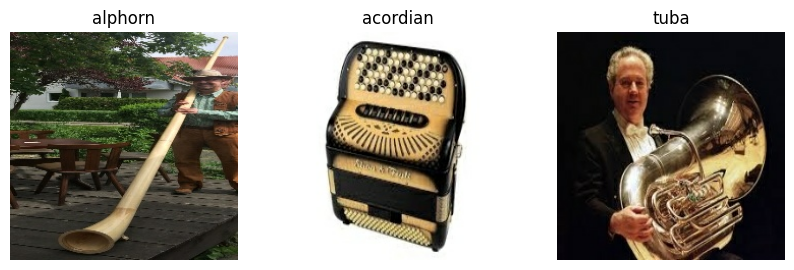

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(3):
    ax = plt.subplot(1, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for images, labels in train_data.take(1):
  print(images.shape)

(32, 224, 224, 3)


### Malte Teil 1 Explo

Text Kapitel

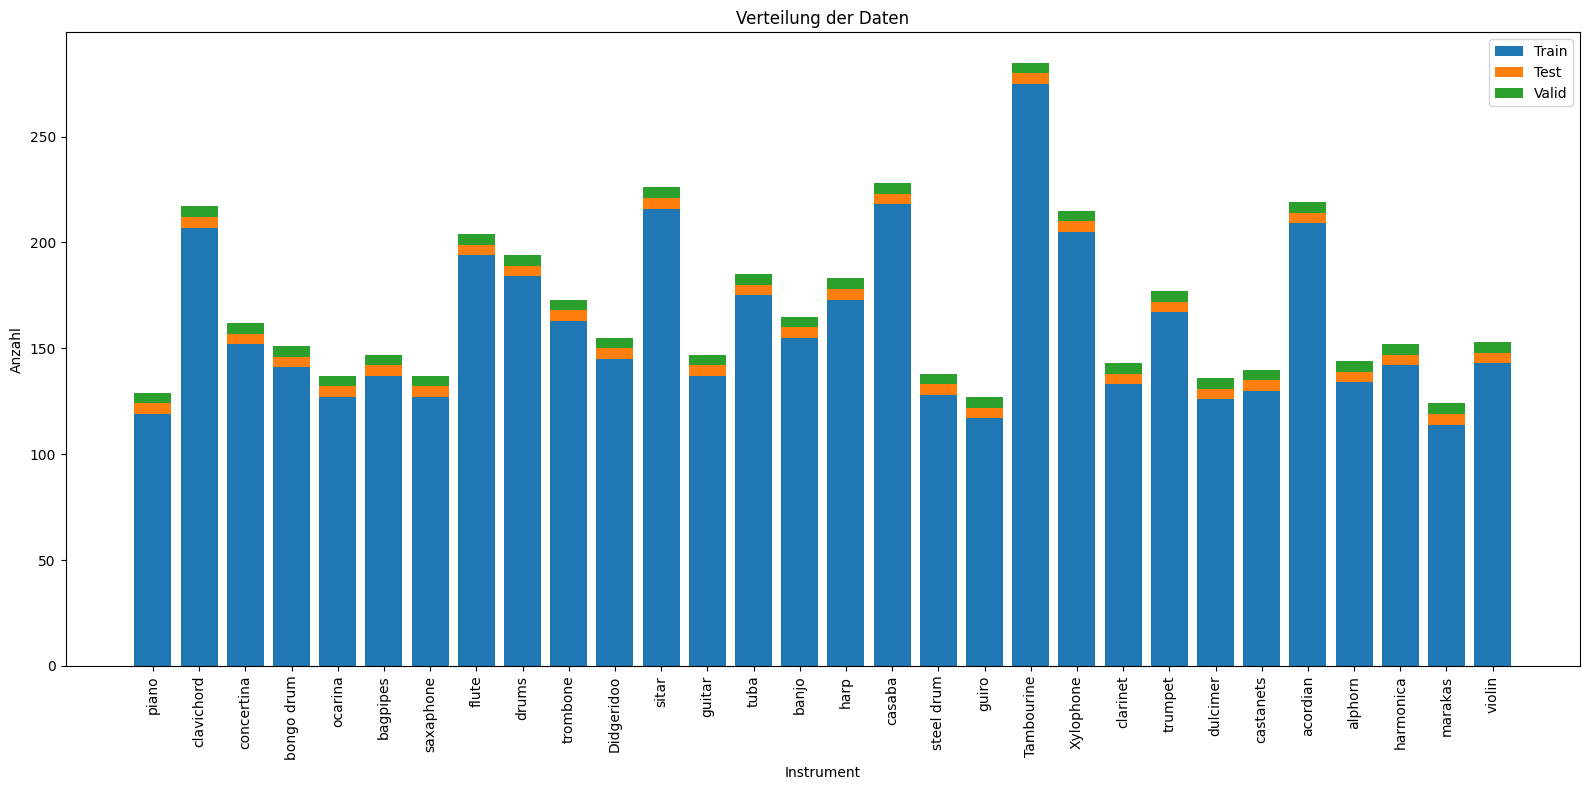

    Instrument  train  test  valid
0        piano    119     5      5
1   clavichord    207     5      5
2   concertina    152     5      5
3   bongo drum    141     5      5
4      ocarina    127     5      5
5     bagpipes    137     5      5
6    saxaphone    127     5      5
7        flute    194     5      5
8        drums    184     5      5
9     trombone    163     5      5
10  Didgeridoo    145     5      5
11       sitar    216     5      5
12      guitar    137     5      5
13        tuba    175     5      5
14       banjo    155     5      5
15        harp    173     5      5
16      casaba    218     5      5
17  steel drum    128     5      5
18       guiro    117     5      5
19  Tambourine    275     5      5
20   Xylophone    205     5      5
21    clarinet    133     5      5
22     trumpet    167     5      5
23    dulcimer    126     5      5
24   castanets    130     5      5
25    acordian    209     5      5
26     alphorn    134     5      5
27   harmonica    14

In [ ]:
def iterate_amount(folder_name):
  '''
  Dies ist eine Funktion um Instrumente und Anzahl der Bilder des jeweiligen
  Instrumentes identifizieren:
  '''

  # Path zum Testdatensatz definieren
  file_path = f"/content/{folder_name}/*"

  # Liste 'files' erstellen.
  #'files' enthält alle Inhalte im Testdatensatz.
  # Die Inhalte sind Ordner mit Bildern des jeweiligen Instruments.
  files = glob(file_path)

  # Dictionary 'file_dict' initiieren.
  file_dict = {}

  # Durch alle Instrument-Ordner in 'files' iterriren:
  for file in files:

      # Liste 'images' erstellen.
      # 'images' enhält alle Bilder des jeweiligen Instrument-Ordners.
      images = glob(f"{file}/*")

      # 'count' als Anzahl der Bilder des jeweiligen Instrument-Ordners definieren.
      count = len(images)

      # 'file_dict' mit den Instrumentennamen als Keys und 'count' (Bildanzahl) als values füllen.
      file_dict[f"{file}".split("/")[3]] = count

  # 'images_per_label' darstellen
  return file_dict

'''
Die Grundidee des folgenden Teilstück des Codes stammt von
https://www.kaggle.com/code/gpiosenka/explore-instruments-data-set und wurde mit
hilfe von GPT-3.5 auf diesen Usecase angepasst.
'''

#Lister aller verfügbaren ordner erstellen
all_sets = ["train", "test", "valid"]

# Mittels der Variable "all_pictures" wird ein dictionary erstellt, in diesem sollen die
# informationen über die einzelnen Instrumente gesammelt werden
all_pictures = {"Instrument": []}
# Da es sinnvoll ist die Daten aller drei sets zu Visualiseren, ist es auch
# sinnvoll diese im selben Datensatz zu sammeln. Demnach wird mittels der ersten
# for-Schleife über die in "all_sets" definierten Ordnernamen itteriert. Die einzelnen
# Ordnernamen werden mittels "folder" in die weiter oben definierte funktion "iterate_amount" eingesetz
for folder in all_sets:
    images_per_label = iterate_amount(folder)
    # Diese for-Schleife geht über die vorhandenen Elemente (.items()) in der vorher
    # mittels iterate_amount(folder) die Daten aller drei Ordner geladen wurden
    for instrument, image in images_per_label.items():
        # an dieser Stelle wird nun überprüft ob der Name des Instruments
        # bereits in der Liste enthalten ist. Dies ist vorallem relevant da nach
        # der iteration über den "train" Ordner bereits alle Instumente vorhanden
        # sind und somit durch das Iterieren über "test" und "valid" keine
        # Duplikate in der "Instrument"-Column entstehen
        if instrument not in all_pictures["Instrument"]:
            # Dies fügt die nicht vorhanden Instumente der Variable "all_pictures" hinzu
            all_pictures["Instrument"].append(instrument)
        # um nun nicht nur eine Liste der einzelnen Instrumente bzw. Labels zu
        # erhalten wird nun in "all_pictures" eine weitere leere Liste für jedes in "folder" enthaltene
        # Element erstellt. Ähnlich wie in der definition von "all_pictures", nur das
        # mittels "all_pictures[folder]=.." dafür gesorgt wird das keine gänzlich neue Liste,
        # sondern ein weiterer Schlüssel in "all_pictures" generiert wird.
        all_pictures[folder] = all_pictures.get(folder, [])
        # um nun die leeren Schlüssel "train","test" und "valid" mit den benötigeten
        # Daten zu befüllen werden die Werte mittels ".append" "all_pictures" hinzugefügt.
        # hierzu wird erneut "all_pictures[folder]" verwendet um die Daten den richtigen
        # Schlüsseln zuordnen zu können. "(image)" referiert nun auf die zweite
        # for-Schleife in Zeile 52. Da hier zwei Variablen zwischen "for" und
        # "in" genannt werden, können die aus "iterate_amount(folder)" erhaltenen werte
        # einzeln abgerufen werden. Mittels "instrument" werden die Labels bzw.
        # Ordnernamen zurückgegeben, da uns nun aber die Summe der verfügbaren Datein
        # interessiert wird "image" angesprochen was auf den zweiten Teil der
        # generierten Informationen referiert.
        all_pictures[folder].append(image)
# um die Daten nun akkurat zusammenzuführen und weiterverarbeiten zu können
# werden die in der liste "all_pictures" generierten Daten nun in einen Pandas Dataframe
# konvertiert
image_count_all_folders = pd.DataFrame(all_pictures)

'''
Visualisierung der Daten
anreiz durch GPT-3.5 https://chat.openai.com/share/dcf8880e-6ee9-4160-a9f2-631eefdf53af
'''
plt.figure(figsize=(16, 8))
bottom_2 = np.add(image_count_all_folders["train"],image_count_all_folders["test"] )
plt.bar(image_count_all_folders["Instrument"], image_count_all_folders["train"], label='Train')
plt.bar(image_count_all_folders["Instrument"], image_count_all_folders["test"], label='Test', bottom=image_count_all_folders["train"])
plt.bar(image_count_all_folders["Instrument"], image_count_all_folders["valid"], label='Valid', bottom=bottom_2)
plt.xlabel('Instrument')
plt.ylabel('Anzahl')
plt.title('Verteilung der Daten')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

print(image_count_all_folders)

#### Interpretation der Ergebnisse



Bereits der Print des Dataframes zeigt das die Ordner "test" und "valid" jeweils 5 Bilder jedes Labels enthalten. Ebenso ist deutlich sichtbar das es eine gewisse Varianz in den verfügbaren Bildern des "train" ordners gibt.
Diese Varianz wird in dem dargestellten Bar-plott nochmals deutlicher. Ebenso ist deutlich sichtbar das die verfügbaren Bilder von "test" und "valid" sich konstant verhalten. Auch dies ist ebenso mit anhand der Tabelle zu belegen

### Malte Teil 2 Explo

TEXT ZUM CODE

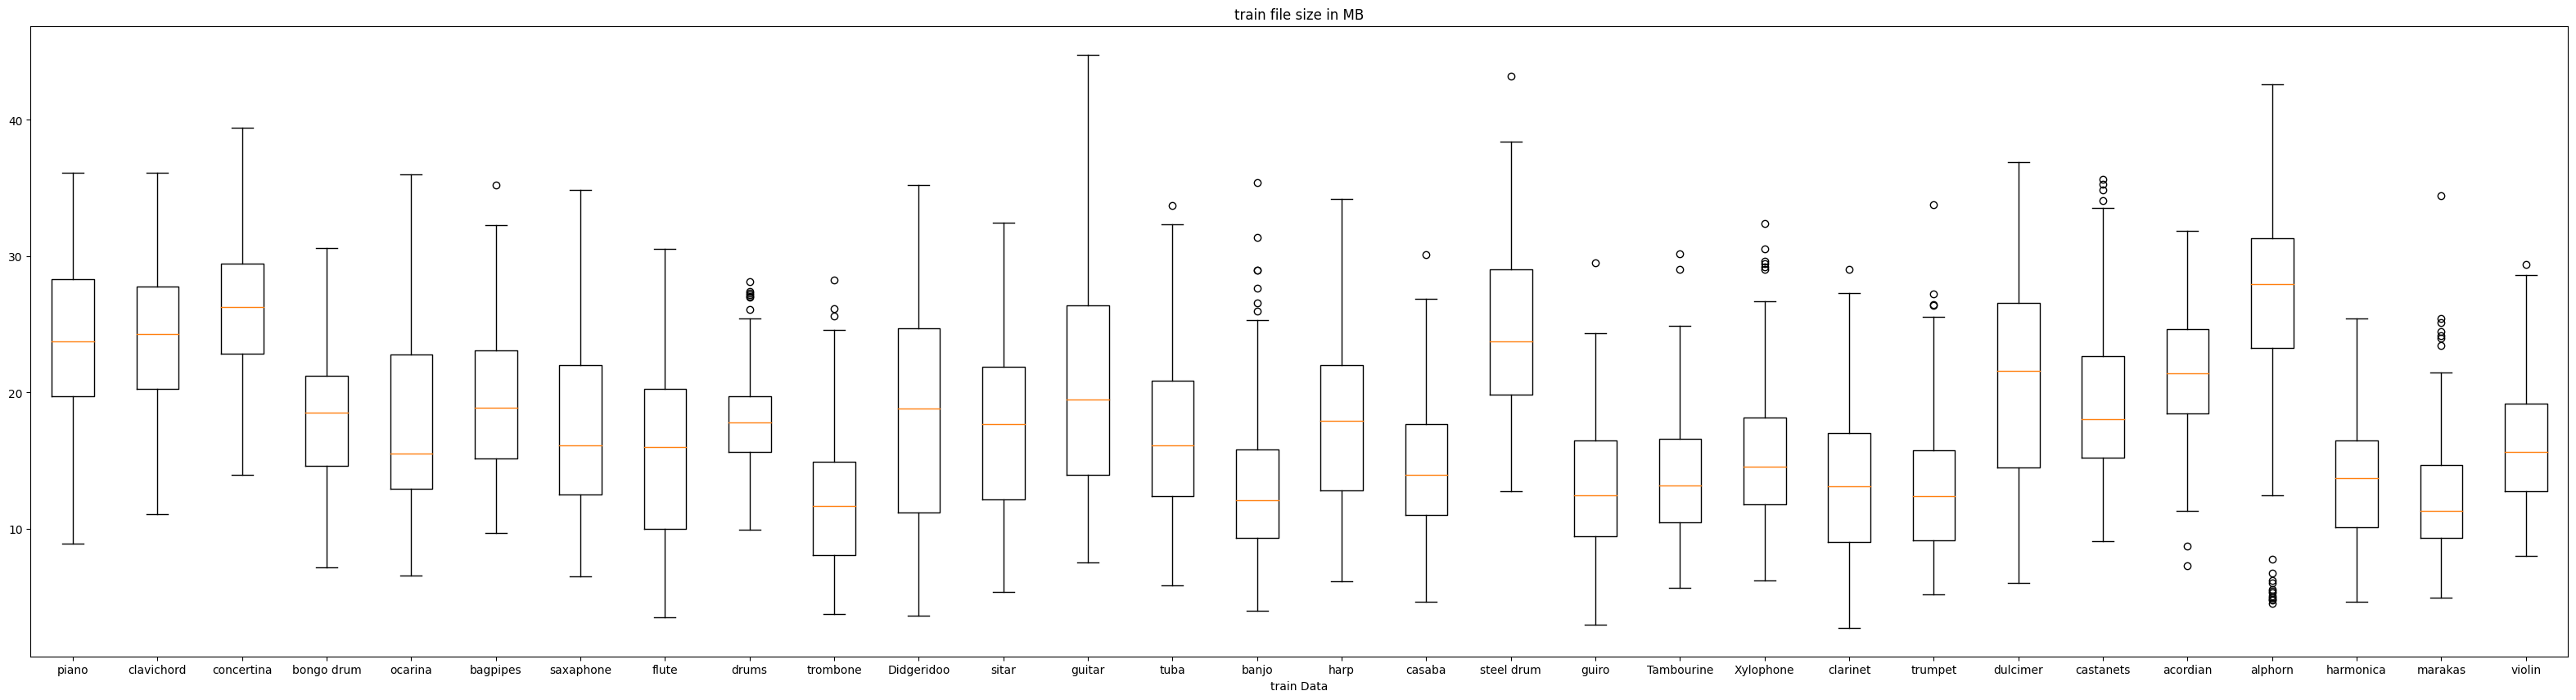

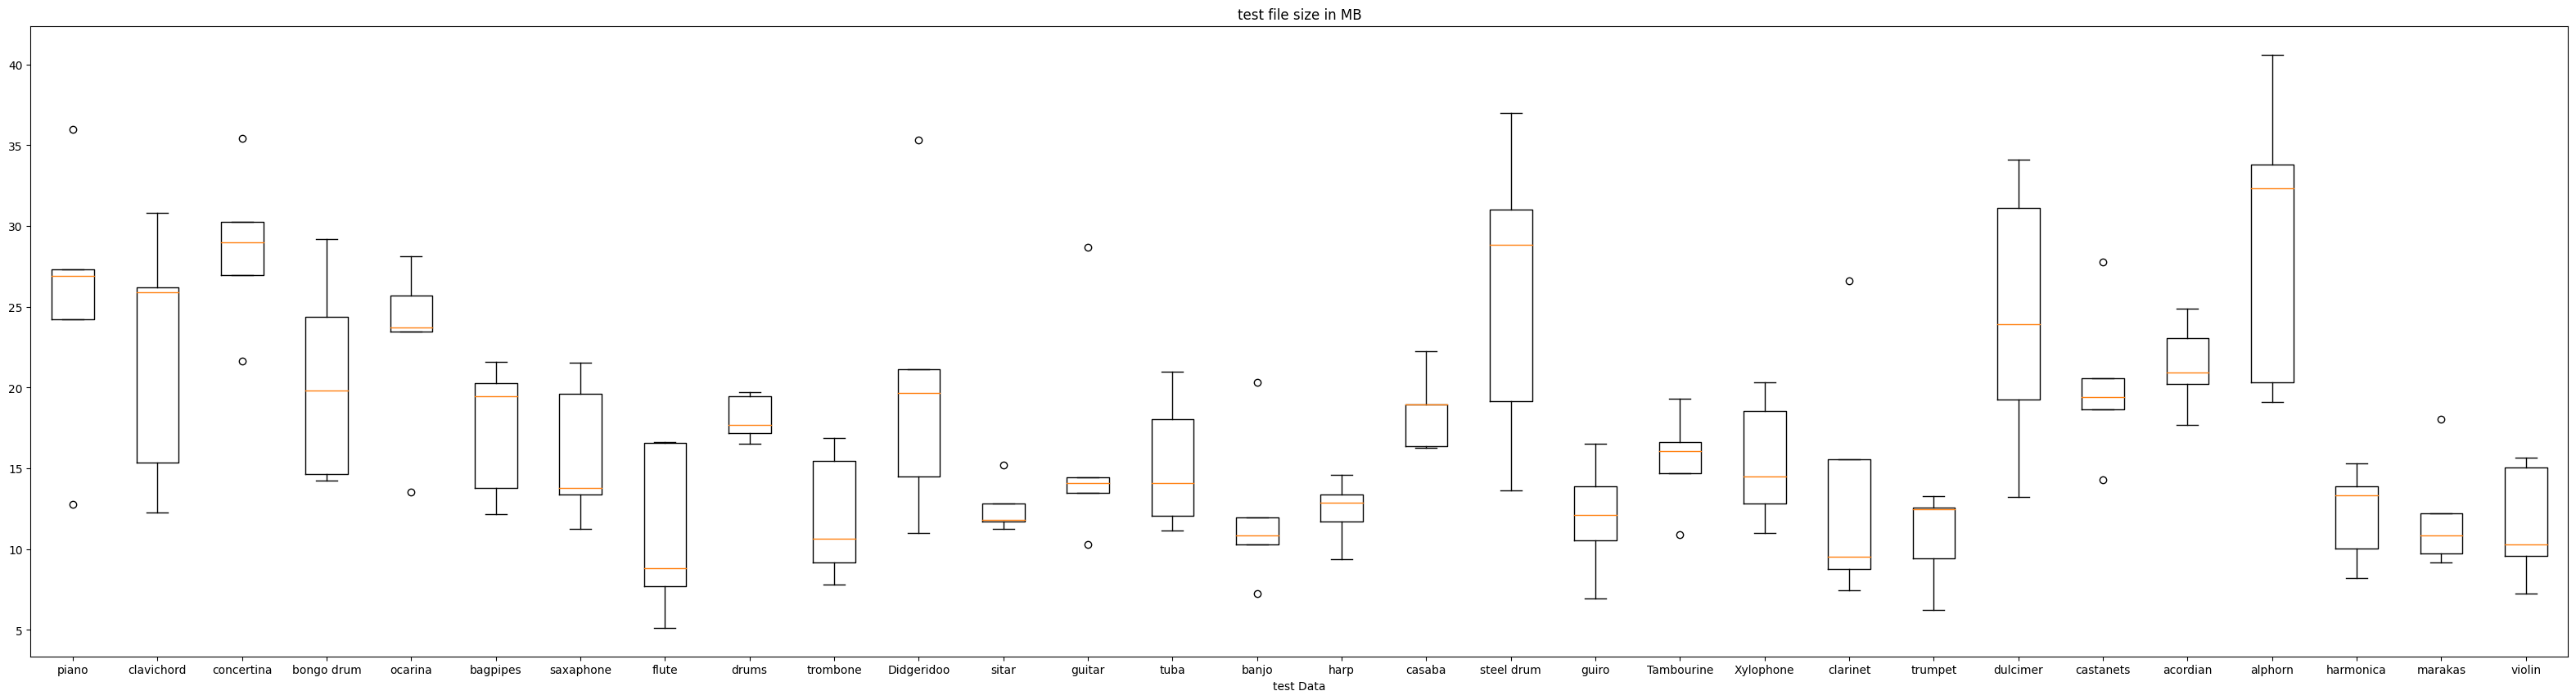

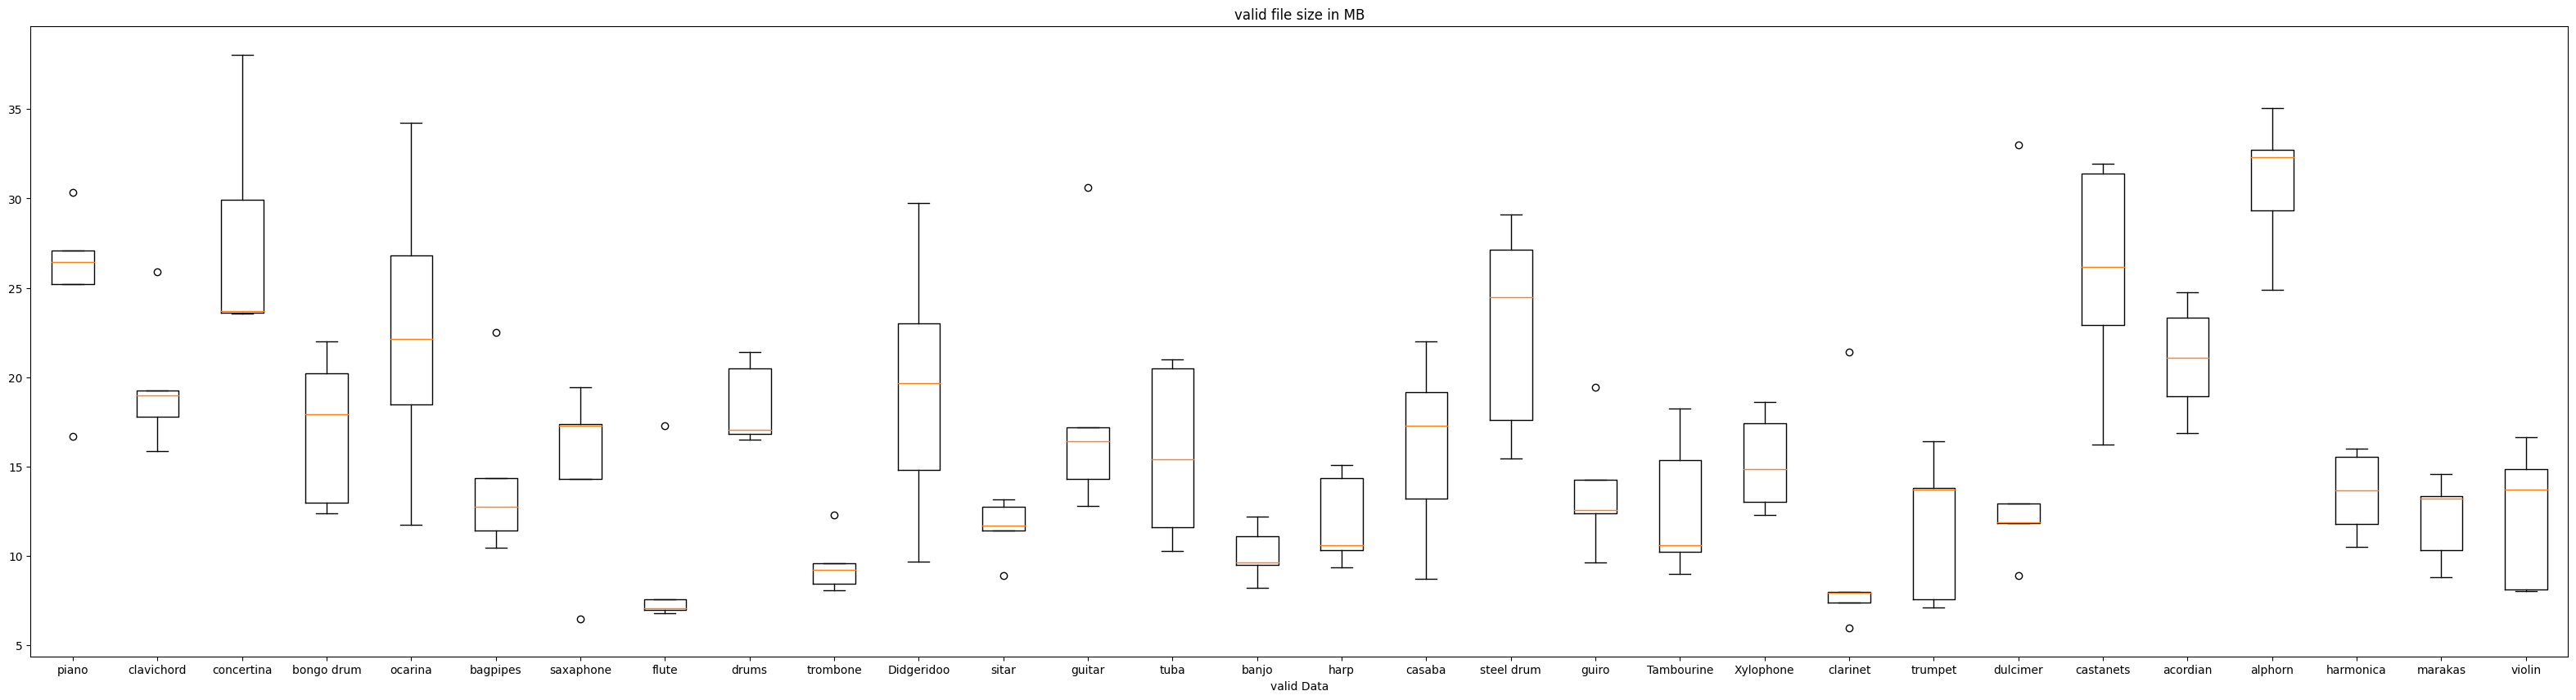

In [ ]:
def iterate_size(folder_name):
  '''
  Dies ist eine Funktion um Instrumente und Anzahl der Bilder des jeweiligen
  Instrumentes identifizieren:
  '''

  # Path zum Testdatensatz definieren
  file_path = f"/content/{folder_name}/*"

  # Liste 'files' erstellen.
  #'files' enthält alle Inhalte im Testdatensatz.
  # Die Inhalte sind Ordner mit Bildern des jeweiligen Instruments.
  files = glob(file_path)

  # Dictionary 'file_dict' initiieren.
  file_dict = {}

  # Durch alle Instrument-Ordner in 'files' iterriren:
  for file in files:

      # Liste 'images' erstellen.
      # 'images' enhält alle Bilder des jeweiligen Instrument-Ordners.
      images = glob(f"{file}/*")

      # 'image_size' als größe der Bilder des jeweiligen Instrument-Ordners definieren.
      # hierbei wird durch 1024 geteilt um die von getsize erhaltenen Bytes direkt
      # in Mega-Bytes umzurechnen. Die "Round()" Funktion sorgt für die Limitation auf
      # zwei nachkomma stellen um bessere Visualisierung zu ermöglichen
      image_size = [round(os.path.getsize(x)/1024, 2) for x in images]

      # 'file_dict' wird mit den Instrumentennamen als Keys und 'image_size' (Bildgröße) als values füllen.
      file_dict[f"{file}".split("/")[3]] = image_size

  # Pandas-Dataframe 'imagessize_per_label' aus 'file_dict' erstellen.
  imagessize_per_label = pd.DataFrame(file_dict.items(), columns=["Instrument", "Größe der Bilder in MB"])

  # 'images_per_label' darstellen
  return imagessize_per_label

'''
Visualisierung der Daten
'''
#Lister aller verfügbaren ordner erstellen
all_sets = ["train", "test", "valid"]
for folder in all_sets:
  imagesize_per_label = iterate_size(folder)
  # Generiert eine liste die nur diejenigen wertes des in all_set enthaltenen labels
  box_train = imagesize_per_label["Größe der Bilder in MB"].tolist()

  #Definiert die Größe des Plotts
  fig = plt.figure(figsize= (40,10))

  plt.boxplot(box_train, labels=imagesize_per_label["Instrument"])
  plt.xlabel(f"{folder} Data")
  plt.title(f"{folder} file size in MB" )
  plt.show()

#### Interpretation der Ergebnisse**

An dieser Stelle wurde ein Boxplot genutzt um zwei dinge herrauszustellen. Mittels des "train" Boxplots kann ein genereller Überblick gewonnen werden wie groß die Daten insgesammt sind woraus sich erste Schlüsse auf die Länge des Trainingsprozesses ziehen lassen. Da die verfügbaren Bilder generell relativ moderat groß sind und auch die Menge (siehe Visualisierung der Verfügbaren Bilder) nicht überschwinglich groß ist, sind keine allzulangen Trainingszeiten zu erwarten.
Spannend ist nun primär der Vergleich der "test" und "valid" Boxplots. Da die Bilder in diesen Ordnern jeweils nur mit 1.jpg bis 5.jpg benannt sind, lässt sich auf den ersten blick nicht feststellen ob die Bilder in diesen Subsets identisch sind. Um nun nicht jedes Bild der beiden Subsets manuel abgleichen zu müssen helfen die Boxplots. Diese zeigen das die Verteilung der Dateigrößen eine große Differenz aufweißt, somit kann darauf geschlossen werden das sich zum großen Teil nicht identische Bilder in den Label-Ordnern von "test" und "valid" befinden.

### Malte Teil 3

Text

In [ ]:
def iterate_shape(folder_name):
    #Erstellt mit der Hilfe von GPT-3.5 -> https://chat.openai.com/share/72c070a8-e5fd-4734-b07f-5700d050582d

    '''
    Diese Funktion identifiziert den Shape der verfügbaren Bildern und ordnet diese den Label-Ordnern zu.
    '''

    # Definition des Pfades
    file_path = f"/content/{folder_name}/*"

    # Liste 'files' erstellen.
    #'files' enthält alle Inhalte im Testdatensatz.
    # Die Inhalte sind Ordner mit Bildern des jeweiligen Instruments.
    files = glob(file_path)

     # Dictionary 'file_dict' initiieren.
    file_dict = {}

    # Durch alle Instrument-Ordner in 'files' iterriren:
    for file in files:

        # Liste 'images' erstellen.
        # 'images' enhält alle Bilder des jeweiligen Instrument-Ordners.
        images = glob(f"{file}/*")

        # 'image_shapes' to store the dimensions (shape) of the images
        image_shapes = []

        # in dieser for-Schleife wird mittels der "cv2" libary die shape der
        # Bilder ermittel. Hierzu greift die Schleife auf die bereits gesammelten
        # Bilder, welcher in der "images" Variable gesichert wurden.
        for image_path in images:
            img = cv2.imread(image_path,)
            height, width, _ = img.shape
            image_shapes.append((width, height))

        # 'file_dict' wird mit den Instrumentennamen als Keys und 'image_shapes' (shape der Bilder) als values füllen.
        file_dict[f"{file}".split("/")[3]] = image_shapes

    # Pandas-Dataframe 'imageshape_per_label' aus 'file_dict' erstellen.
    imageshape_per_label = pd.DataFrame(file_dict.items(), columns=["Instrument", "Shape der Bilder"])

    # Gibt den höchsten Wert wieder
    print(imageshape_per_label.max())

    # Gibt den niedrigsten Wert wieder
    print(imageshape_per_label.min())

#Lister aller verfügbaren ordner erstellen
all_sets = ["train", "test", "valid"]

#Diese kleine for-Schleife soll die oben definierte Funktion durchlaufen um Ergebnisse für alle drei
#Verzeichnisse ("train", "test", "valid") wiederzugeben.
for folder in all_sets:
  imagesize_per_label = iterate_shape(folder)

Instrument                                                     violin
Shape der Bilder    [(224, 224), (224, 224), (224, 224), (224, 224...
dtype: object
Instrument                                                 Didgeridoo
Shape der Bilder    [(224, 224), (224, 224), (224, 224), (224, 224...
dtype: object
Instrument                                                     violin
Shape der Bilder    [(224, 224), (224, 224), (224, 224), (224, 224...
dtype: object
Instrument                                                 Didgeridoo
Shape der Bilder    [(224, 224), (224, 224), (224, 224), (224, 224...
dtype: object
Instrument                                                     violin
Shape der Bilder    [(224, 224), (224, 224), (224, 224), (224, 224...
dtype: object
Instrument                                                 Didgeridoo
Shape der Bilder    [(224, 224), (224, 224), (224, 224), (224, 224...
dtype: object


#### Interpretation der Ergebnisse
Da es sich in diesem Fall um Tupelt handelt ist die Visualiseriung ein wenig Komplexer. Aus diesem Grund wurde die Entscheidung getroffen nur das Minimum bzw. Maximum zu betrachten. Aus diesem geht hervor dass sich alle Bilder in der exakt gleichen Größe befinden. Diese information ist wichtig, da die für das Modell aufgestellten Parameter sich an dieser orrientieren. Wären die Bilder von unterschiedlicher größe wäre dies unvorteilhaft und es wäre eine Datenvorverarbeitung nötig damit alle Bilder die selbe Größe erhalten.

# Modellerstellung
Im folgenden Abschnitt werden alle notwendigen Aspekte der Modellerstellung durchlaufen.

Hierzu gehören:
 * die Datenvorverarbeitung,
 * das Erstellen einer Modellarchitektur,
 * das Training und Testen des Modells,
 * sowie das Fine-Tuning.

Zum Abschluss wird die Performance des Modells mittels Cross-Validierung geprüft.

## Datenvorverarbeitung

Die Datenvorverarbeitung bietet die Möglichkeit, die Bilder zu verändern. Ein Mögliches Feld sind Augmentationen, welche verwendet werden, um die Menge der Bilder zu erhöhen oder zu diversifizieren. Beispiele hierfür sind das verändern des Kontrastes, sowie das spiegeln und drehen der Bilder.

Ein weiterer Anwendungsbereich ist die reduktion der Bilddaten. Dies kann sinnvoll sein, wenn der Detailgrad der Bilder hörer ist, als es für den Anwendungsfall von nöten ist. Da die vorliegenden Bilddaten mit 224x224 Pixeln in RGB verhältnismäßig groß sind, wird mit derartigen Methoden experimentiert.

Im Folgenden werden die Bilder verkleinert, von Farb- zu schwarz-weiß-Bildern verändert und normalisiert.

Referenzen:

https://www.tensorflow.org/tutorials/images/classification

https://keras.io/guides/preprocessing_layers/

https://chat.openai.com/share/4211047c-1904-4c0e-9ad1-9dc3c590233d


### Ändern der Farbkanäle



Im Folgenden werden die Farbkanäle von drei auf einen reduziert. Dies konvertiert die Bilder von Farb- zu schwarz-weiß Bildern.

Hierfür wird zunächst die Funktion `layers.Grayscale()` definiert. Hierdurch werden Coderedundanzen vermieden. Die Funktion nimmt das Argument `subset`, welches auf den jeweiligen Datensatz zeigt.

Im Anschluss wird die Funktion für Trainings-, Test- und Validierungsdatansatz aufgerufen und die Ergebnisse mit dem Prefix *greyscale_* gesichert.

Mittels der Funktion `.shape` kann im Anschluss erneut das Format der Bilder angezeigt werden. Man kann hier erkennen, dass sich die Farbkanäle von drei auf einen reduziert haben.

Schließlich werden die konvertierten Bilder visuell dargestellt.

In [ ]:
def to_greyscale(subset):
  '''
  Diese Funktion kovertiert Farbbilder in schwarz-weiß Bilder.

  *Args:
  subset: Gibt den Datensatz an, der konvertiert werden soll.
  '''

  return subset.map(lambda x,y: (keras_cv.layers.Grayscale()(x), y))

In [ ]:
# Konvertieren der Unterdatensätze in schwarz-weiß Bilder

greyscale_train_data = to_greyscale(train_data)
greyscale_test_data = to_greyscale(test_data)
greyscale_valid_data = to_greyscale(valid_data)

In [ ]:
for images, labels in greyscale_train_data.take(1):
  print(images.shape)

(32, 224, 224, 1)


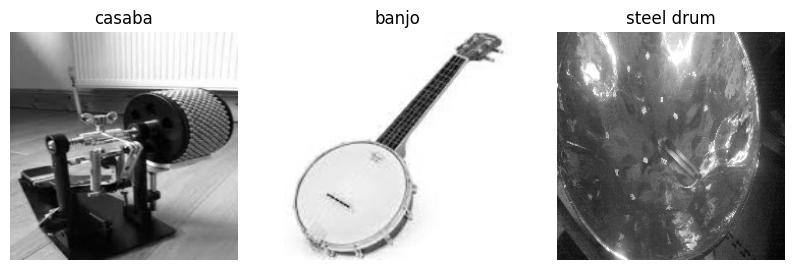

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in greyscale_train_data.take(1):
  for i in range(3):
    ax = plt.subplot(1, 3, i + 1)

    #cmap gibt die Farbkanäle an.
    #Da der Default RGB ist, muss dieser für schwarz-weiß Bilder definiert werden.
    plt.imshow(images[i].numpy().astype("uint8"), cmap="gray")

    plt.title(class_names[labels[i]])
    plt.axis("off")

### Ändern der Bildgröße


In diesem Abschnitt wird die Bildgröße verändert.

Zunächst wird die Funktion `resize()` definiert. Hierdurch werden Coderedundanzen vermieden. Die Funktion nimmt das Argument `subset`, welches auf den jeweiligen Datensatz zeigt. Zusätzlich werden `height`und `width`übergeben. Hierüber werden die gewünschte Breite und Höhe des Outputbildes definiert.

Im Anschluss wird die Funktion für Trainings-, Test- und Validierungsdatansatz aufgerufen und die Ergebnisse mit dem Prefix *resize_* gesichert.

Mittels der Funktion `.shape` kann im Anschluss erneut das Format der Bilder angezeigt werden. Man kann hier erkennen, dass sich die Anzahl der Pixel in Höhe und Breite reduziert hat.

Schließlich werden die konvertierten Bilder visuell dargestellt. Die verschlechterung der Qualität ist deutlich sichtbar.

In [ ]:
def resize(subset, height, width):
  '''
  Diese Funktion verändert die Größe von Bildern.

  *Args:
  subset: Gibt den Datensatz an, der konvertiert werden soll.
  height: Gibt die gewünschte Höhe an.
  width: Gibt die gewünschte Breite an.
  '''
  return subset.map(lambda x,y: (tf.keras.layers.Resizing(height, width)(x), y))

In [ ]:
# Verkleinerung der Bilder der Unterdatensätze

resized_train_data = resize(train_data, 120,120)
resized_test_data = resize(test_data, 120,120)
resized_valid_data = resize(valid_data, 120,120)

In [ ]:
for images, labels in resized_train_data.take(1):
  print(images.shape)

(32, 120, 120, 3)


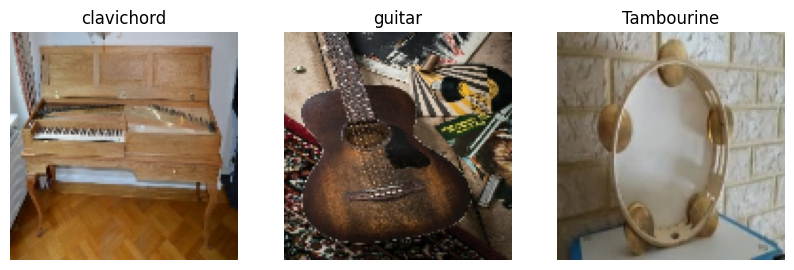

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in resized_train_data.take(1):
  for i in range(3):
    ax = plt.subplot(1, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))

    plt.title(class_names[labels[i]])
    plt.axis("off")

### Normalisieren der Pixelwerte



Die Pixelwerte der jeweiligen Bilder liegen zwischen 0 und 255.

Um Werte zwischen 0 und 1 zu erlangen, werden die Pixelwerte daher durch 255 geteilt.

In [ ]:
# Minimum und Maximum der Pixel eines Beispielbildes abfragen

image_batch, labels_batch = next(iter(train_data))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 245.0


In [ ]:
def normalize(subset):
  return subset.map(lambda x,y: (tf.keras.layers.Rescaling(1/255)(x), y))

In [ ]:
# Normalisieren der Unterdatensätze

normal_train_data = normalize(resized_train_data)
normal_test_data = normalize(resized_test_data)
normal_valid_data = normalize(resized_valid_data)

In [ ]:
# Minimum und Maximum der Pixel nach dem Normalisieren abfragen

image_batch, labels_batch = next(iter(normal_test_data))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.00013071697 1.0


### One-Hot Encoding



Da der Datensatz Kategorische Label hat, welche für CNNs ungeeignet sind, müssen diese Dummy Codiert werden.

Hierfür wird zunächst die Funktion `one_hot ` definiert. Diese nimmt das Argument `subset `, was auf den Datensatz zeigt, der Dummy codiert werden soll.

Im Anschluss wird die Funktion auf die drei Unterdatensätze angewandt.

In [ ]:
# Ausganslage analysieren

for image, label in train_data.take(1):
    print("Label:", label.numpy())

Label: [27  2  4 17 14  8 21 11  9 29 10 17 25 24  8 12 19 14  4 17  1  0 19 15
  7  8  3 12 17  3 28  9]


In [ ]:
def one_hot(subset):
  '''
  Diese Funktion Dummy-codiert die Labels eines Datensatzes

  *Args:
  subset: Gibt den Datensatz an der Dummy codiert werden soll.
  '''
  return subset.map(lambda x,y: (x, tf.one_hot(y,30)))

In [ ]:
# Dummy codieren der Unterdatensätze

one_hot_train_data = one_hot(normal_train_data)
one_hot_test_data = one_hot(normal_test_data)
one_hot_valid_data = one_hot(normal_valid_data)

In [ ]:
# Label überprüfen

for image, one_hot_label in one_hot_train_data.take(1):
    print("One-Hot Label:", one_hot_label.numpy())

One-Hot Label: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [ ]:
# Initialize a variable to count the number of images
num_images = 0

# Iterate through the dataset and count the number of images
for x, y in one_hot_train_data:
    num_images += x.shape[0]

# Print the number of images in normal_train_data
print("Number of images in normal_train_data:", num_images)

Number of images in normal_train_data: 4793


### Augmentation



Mit 4793 Trainingsbildern für 30 Klassen ist der Datensatz recht klein, was zu overfitting führen kann. Ein Lösungsansatz ist hier die verwendung von Bild Augmentationen. Hier werden die vorhandenen Bilder verändert, sodass das Modell pro Epoche nicht immer das gleiche Bild, sondern eine veränderte Version des Bildes bekommt. Dies wiederum kann bei overfitting helfen, da das Modell so schlechter 'auswendig lernen' kann, sondern eher generalisieren muss.

Im folgenden Abschnitt werden daher verschiedenne Methoden der Augmentation auf den Datensatz angewandt.

*Referenzen:*

https://keras.io/guides/preprocessing_layers/

In [ ]:
#
def augment(subset):
  '''
  Funktion verändert die Bilder eines Datensatzes.
  *Args:
  subset: Gibt den Datensatz an dessen Bilder verändert werden soll.
    '''
  augmentation = tf.keras.Sequential(
    [
        #tf.keras.layers.RandomFlip("horizontal"),
        #tf.keras.layers.RandomRotation(0.1),
        #tf.keras.layers.RandomZoom(0.1),
        tf.keras.layers.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.RandomRotation(0.2),
    ]
  )
  augmented_data = augmentation(subset)
  return augmented_data


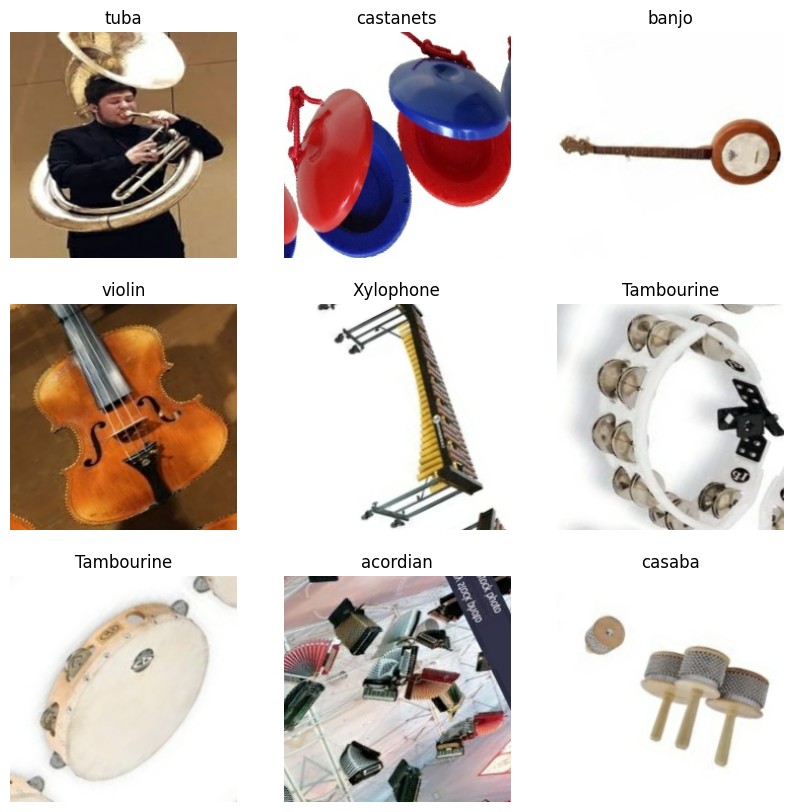

In [ ]:
# Augmentationen visualisieren

plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(9):
    augmented = augment(images[i])
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented.numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Vergleichs-Architekturen

Wie eingangs beschrieben soll zur Lösung der beschriebenen Herausforderung ein Modell entwickelt werden, dass für die Bildklassifizierung von Multiklassen-Problemen geeignet ist. Hierfür werden folgend mehrere Modelle vorgestellt, die auf ähnliche Problemstellungen angewendet wurden und gute Resultate erzielt haben.

Es gibt eine Vielzahl grundlegender Konzepte, die für diesen spezifischen Anwendungsfall geeignet wären. Dazu gehören beispielsweise „Support Vector Machines (SVMs)“, Ensemble Methoden wie „Random Forests“, „Convolutional Neural Networks (CNNs)“ oder auch „Artificial Neural Networks (ANNs)“. Alle diese Konzepte haben ihre individuellen Vor- und Nachteile. Besonders gut geeignet sind CNNs, denn diese bieten eine überzeugende Lösung für die Bildklassifikation. CNNs erzielen State-of-the-Art-Leistung in zahlreichen Anwendungen und sind in der Lage, automatisch relevante Merkmale aus den Daten zu extrahieren, ohne manuelles Feature Engineering. Dank ihrer Skalierbarkeit passen sie sich gut an verschiedene Aufgaben an und können mit Transfer Learning Zeit und Ressourcen sparen. Ihre Flexibilität, Vielseitigkeit und die fortlaufende Forschung in diesem Bereich machen sie zur bevorzugten Wahl. Darüber hinaus sind Ressourcen wie Open-Source-Frameworks leicht verfügbar, was ihre Implementierung erleichtert. Insgesamt sind CNNs eine leistungsstarke und zukunftsweisende Option für die Bildklassifikation. Der Fokus liegt auf vier verschiedenen CNN-Modellen: AlexNet, VGG16, VGG19 und DenseNet.

Das AlexNet wurde im Jahr 2012 von Alex Krizhevsky, Ilya Sutskever und Geoffrey Hinton entwickelt. Es markierte einen bahnbrechenden Moment in der Geschichte des Deep Learning und der Bildklassifikation. Dieses Modell gewann 2012 die ImageNet Large Scale Visual Recognition Challenge (ILSVRC) und demonstrierte erstmals die Leistungsfähigkeit von tiefen neuronalen Netzwerken in der Bildverarbeitung. AlexNet wurde zwar ursprünglich für die Bildklassifikation entwickelt, aber im Laufe der Zeit vermehrt für Computer-Vision-Anwendungen eingesetzt. Dazu gehören Objekt- und Gesichtserkennung. Dieses Modell zeichnet sich durch seine einfache Architektur aus, was es zu einem guten Ausgangspunkt für grundlegende Bildklassifikationsaufgaben macht. Dem gegenüber steht wiederum die Anforderung, dass eine ausreichende Menge an Trainingsdaten benötigt wird und es rechenintensiv ist.

Die VGG-Modelle wurden 2014 von der Visual Geometry Group (VGG) an der Universität Oxford entwickelt. Die erste öffentliche Anwendung erfolgte ebenso wie beim AlexNet im Rahmen des ILSVRC-Wettbewerbs. Die VGG-Modelle sind für ihre tiefe und symmetrische Architektur bekannt, die vor allem in der Bildklassifikation und -segmentierung weit verbreitet ist. Hinzu kommt zudem ihr Einsatz in Transfer-Learning-Szenarien. Die Stärke dieser Modelle liegt in ihrer Einfachheit und Symmetrie, die sie leicht verständlich und implementierbar machen. Allerdings sind diese Modelle im Vergleich zu moderneren CNN-Architekturen rechenintensiv und haben eine hohe Anzahl von Parametern, sodass die Trainingszeit und die Speicheranforderungen höher sind.

DenseNet wurde im Jahr 2017 von Gao Huang, Zhuang Liu, Laurens van der Maaten und Kilian Q. Weinberger vorgestellt. Es repräsentiert eine Weiterentwicklung der Convolutional Neural Networks (CNNs). Die Grundidee hinter DenseNet besteht darin, eine dichtere Verbindung zwischen den Schichten herzustellen, sodass jede Schicht Zugriff auf die Ausgabemerkmale aller vorherigen Schichten erhält. Dies führt zu einer höheren Effizienz bei der Merkmalsextraktion und einem besseren Informationsfluss im Netzwerk. Dieses Modell zeichnet seine Effizienz aus, die es ermöglicht mit wenigen Parametern auszukommen und dennoch leistungsstarke Ergebnisse zu erzielen. Im Vergleich zu anderen tiefen Netzwerken erfordert DenseNet weniger Trainingsdaten, um das volle Potenzial auszuschöpfen. Die Architektur von DenseNet macht es besonders geeignet für Szenarien mit begrenzten Ressourcen und bietet dennoch eine hohe Genauigkeit. Es ermöglicht auch eine leichtere Interpretierbarkeit und Implementierung aufgrund seiner klaren und strukturierten Verbindungen zwischen den Schichten. Insgesamt ist das DenseNet ein bedeutender Fortschritt im Bereich der Convolutional Neural Networks und eine geeignete Option für die Bildklassifikation, insbesondere wenn Effizienz und Leistung im Vordergrund stehen.

## Modellarchitektur



### Vorgehen und Parameter-Tuning

Die Literaturrecherche zeigte verschiedene CNN-Architekturen, welche gute bis sehr gute Ergebnisse in der Objekterkennung erlangen. Die kleinste davon ist AlexNet. Aus diesem Grund wird zunächst eine AlexNet Architektur erstellt, um diese als Referenz und Grundlage zu verwenden.

Von hier aus wurde das Modell mittels der Trainingsdaten trainiert und die Leistungsfähigkeit des Modells anhand des Testdatensatzes bewertet, um passende Änderungen vorzunehmen. Die Validierungsdaten wurden im Sinne der Hold-Out-Methode erst nach Abschluss des Tunings verwendet, um die Güte des Modells bewerten zu können.

Die Ergebnisse der AlexNet Architektur zeigen deutlich, dass hier kein Lernerfolg stattgefunden hat. Es gibt keine signifikante Verbesserung in der Leistungsfähigkeit des Modells auf den Testdaten. Des Weiteren lässt der große Unterschied zwischen der Genauigkeit des Modells auf den Trainings- und Testdaten auf Overfitting schließen(Grafik 1).

Um hier bessere Ergebnisse zu erzielen, wurden zunächst die Kernel Size und Strides in Anlehnung an die ResNet Architektur verändert. Aufgrund der begrenzten CPU-Leistung konnte das Modell so jedoch nicht trainiert werden.

Um dem entgegenzuwirken, wurden die Bilder von 224x224 RGB auf 100x100 Schwarz-Weiß verändert, um das Modell so zu verkleinern. Dies ermöglichte das Training. Die Daten zeigen nun einen deutlichen Lernerfolg. Bei 20 Epochen war die beste Validation Accuracy 70,67. Mit einer Trainings Accuracy von 97,60 kann jedoch deutlich ein Overfitting festgestellt werden (Grafik 2).

Daraufhin wurde das Format der Bilder auf 100x100 RGB angepasst. Bei 20 Epochen war die beste Validation Accuracy 77,33 mit einer Trainings Accuracy von 97,37. Die Leistungsfähigkeit konnte also verbessert werden, das Problem des Overfittings wurde jedoch nicht gelöst (Grafik 3).

Um das Overfitting zu vermeiden, wurden verschiedene Augmentation Layer in das Modell inkludiert. So erhält das Modell bei gleicher Datensatzgröße verschiedene Varianten desselben Bildes. Zusätzlich wurden Dropout Layer mit einer Drop-out Rate von 0,6 aufgenommen. Die Ergebnisse zeigen deutlich, dass das Overfitting weniger wurde. Dennoch ist das Modell noch immer Overfitted und auch die Validation Accuracy ist nicht weiter gestiegen (Grafik 4).

Um den Lernerfolg des Modells zu erhöhen, wurde das Modell um einige Layer erweitert. Die Daten zeigen jedoch, dass das Modell selbst noch mit 100 Epochen Underfitted. Die beste Validation Accuracy lag bei 66,00. Da es aufgrund der eingeschränkten Rechenkapazität nicht möglich war, das Modell für mehr Epochen zu trainieren, wurden andere Parameter verändert (Grafik 5).

So wurde Drop out rate auf 0,4 reduziert. Des Weiteren wurden die Bilder auf 120x120 umformatiert, und eine RandomCrop Layer der größe 100x100 in das Modell implementiert. Mit einer Validation Accuracy von 74,76 bei 100 Epochen konnte das Modell so verbessert werden. Dennoch ist noch immer ein Underfitting zu sehen (Grafik 6).

Schließlich wurde die Drop-out Rate weiter auf 0,2 gesenkt. Hier konvergiert das Modell zum ersten Mal. Dies geschieht ungefähr bei Epoche 93. Hier wird eine Validation Accuracy von 74,67 erzielt. Da dieses Modell konvergiert ist und eine für uns ausreichende Leistungsfähigkeit gezeigt hat, wurden hier keine weiteren Änderungen mehr vorgenommen (Grafik 7).


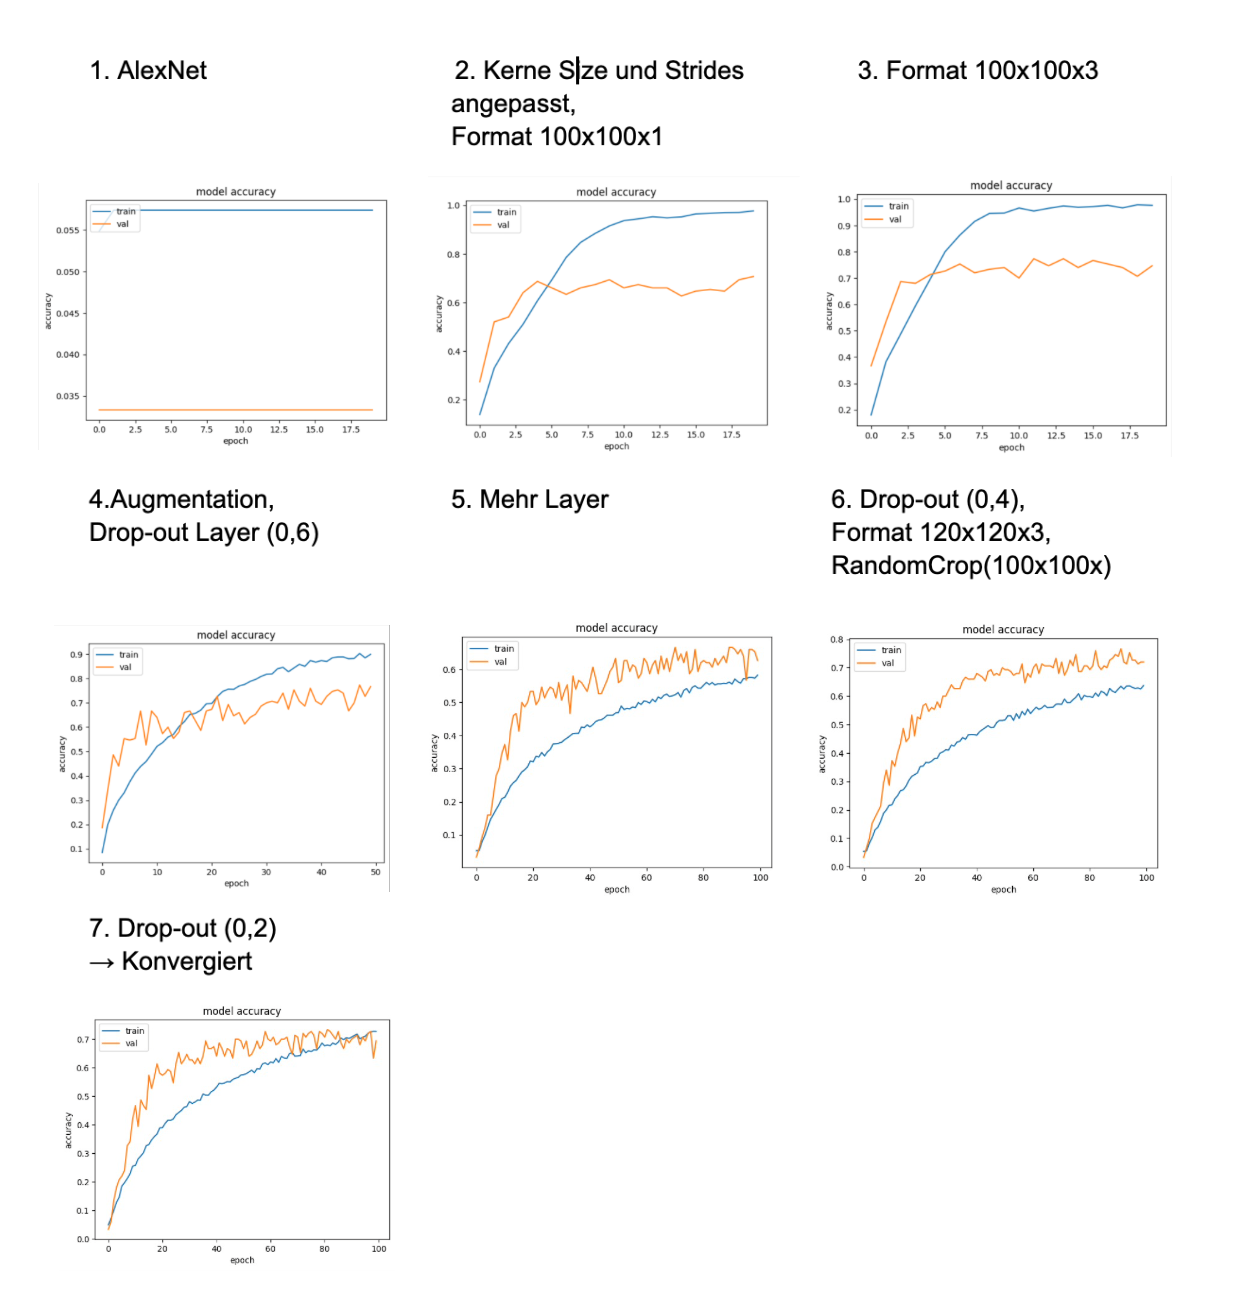


*Referenzen:*

https://medium.com/@siddheshb008/alexnet-architecture-explained-b6240c528bd5

https://towardsdatascience.com/implementing-alexnet-cnn-architecture-using-tensorflow-2-0-and-keras-2113e090ad98

https://keras.io/examples/vision/image_classification_from_scratch/

https://towardsdatascience.com/build-your-own-deep-learning-classification-model-in-keras-511f647980d6

https://keras.io/guides/sequential_model/

https://towardsdatascience.com/deep-learning-3-more-on-cnns-handling-overfitting-2bd5d99abe5d

https://machinelearningmastery.com/how-to-reduce-overfitting-with-dropout-regularization-in-keras/



### Verlauf der Architekturen

In [ ]:
'''
AlexNet Model
'''

model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(
    input_shape= (224,224,3),
    filters=96,
    kernel_size=(11,11),
    strides=(4,4),
    activation="relu",
    ))
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(3,3),
    strides=(2,2)
))
model.add(tf.keras.layers.Conv2D(
    filters=256,
    kernel_size=(5,5),
    strides=(1,1),
    activation="relu",
    padding="same"
))
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(3,3),
    strides=(2,2)
))
model.add(tf.keras.layers.Conv2D(
    filters=384,
    kernel_size=(3,3),
    strides=(1,1),
    activation="relu",
    padding="same"
))
model.add(tf.keras.layers.Conv2D(
    filters=256,
    kernel_size=(3,3),
    strides=(1,1),
    activation="relu",
    padding="same"
))
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(3,3),
    strides=(2,2)
))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(
    units=4096,
    activation="relu"
))
model.add(tf.keras.layers.Dense(
    units=4096,
    activation= "relu"
))
model.add(tf.keras.layers.Dense(
    units=30,
    activation="softmax"
))


In [ ]:
'''
Angepasste Kernel size, Strides und Input Shape
'''

model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(
    input_shape= (100,100,3),
    filters=96,
    kernel_size=(3,3),
    strides=(1,1),
    activation="relu",
    ))
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(3,3),
    strides=(2,2)
))
model.add(tf.keras.layers.Conv2D(
    filters=256,
    kernel_size=(1,1),
    strides=(1,1),
    activation="relu",
    padding="same"
))
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(3,3),
    strides=(2,2)
))
model.add(tf.keras.layers.Conv2D(
    filters=384,
    kernel_size=(3,3),
    strides=(1,1),
    activation="relu",
    padding="same"
))
model.add(tf.keras.layers.Conv2D(
    filters=256,
    kernel_size=(1,1),
    strides=(1,1),
    activation="relu",
    padding="same"
))
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(3,3),
    strides=(2,2)
))
model.add(tf.keras.layers.Dropout(0.6))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(
    units=4096,
    activation="relu"
))
model.add(tf.keras.layers.Dense(
    units=30,
    activation="softmax"
))



In [ ]:
'''
Mit Augmentationen
'''
model = tf.keras.Sequential()
model.add(tf.keras.layers.RandomFlip("horizontal"))
model.add(tf.keras.layers.RandomRotation(0.2)),
model.add(tf.keras.layers.RandomZoom(0.1)),
model.add(tf.keras.layers.Conv2D(
    input_shape= (100,100,3),
    filters=96,
    kernel_size=(3,3),
    strides=(1,1),
    activation="relu",
    #padding=0,
    ))
##kleineres Kernel würde besser zu diesem MaxPooling passen
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(3,3),
    strides=(2,2)
))
model.add(tf.keras.layers.Conv2D(
    filters=256,
    kernel_size=(1,1),
    strides=(1,1),
    activation="relu",
    padding="same"
))
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(3,3),
    strides=(2,2)
))
model.add(tf.keras.layers.Conv2D(
    filters=384,
    kernel_size=(3,3),
    strides=(1,1),
    activation="relu",
    padding="same"
))
model.add(tf.keras.layers.Conv2D(
    filters=256,
    kernel_size=(1,1),
    strides=(1,1),
    activation="relu",
    padding="same"
))
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(3,3),
    strides=(2,2)
))
model.add(tf.keras.layers.Dropout(0.6))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(
    units=4096,
    activation="relu"
))
model.add(tf.keras.layers.Dense(
    units=30,
    activation="softmax"
))




### Finale Architektur

In [ ]:
# Architektur des Modells erstellen

# Sequential-Modell initiieren
model = tf.keras.Sequential()

# Augementationen einfügen
model.add(tf.keras.layers.RandomFlip("horizontal"))
model.add(tf.keras.layers.RandomRotation(0.2)),
model.add(tf.keras.layers.RandomZoom(0.1)),
model.add(tf.keras.layers.RandomCrop(100,100)),

# Input Layer definieren
model.add(tf.keras.layers.Conv2D(
    input_shape= (100,100,3),
    filters=96,
    kernel_size=(2,2),
    strides=(1,1),
    activation="relu",
    ))

# Mehrere Convolution und MaxPooling Layer einfügen
model.add(tf.keras.layers.Conv2D(
    filters=160,
    kernel_size=(3,3),
    strides=(2,2),
    activation="relu",
    padding="same"
))
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(3,3),
    strides=(2,2)
))
model.add(tf.keras.layers.Conv2D(
    filters=160,
    kernel_size=(2,2),
    strides=(1,1),
    activation="relu",
    padding="same"
))
model.add(tf.keras.layers.Conv2D(
    filters=256,
    kernel_size=(3,3),
    strides=(2,2),
    activation="relu",
    padding="same"
))
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(3,3),
    strides=(2,2)
))
model.add(tf.keras.layers.Conv2D(
    filters=256,
    kernel_size=(2,2),
    strides=(1,1),
    activation="relu",
    padding="same"
))
model.add(tf.keras.layers.Conv2D(
    filters=384,
    kernel_size=(3,3),
    strides=(2,2),
    activation="relu",
    padding="same"
))
model.add(tf.keras.layers.Conv2D(
    filters=256,
    kernel_size=(1,1),
    strides=(1,1),
    activation="relu",
    padding="same"
))
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(3,3),
    strides=(2,2)
))

# Dropout Layer einfügen
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(
    units=4096,
    activation="relu"
))

# Output Layer einfügen
model.add(tf.keras.layers.Dense(
    units=30,
    activation="softmax"
))


In [ ]:
# Hierarchisches Diagram des Modells darstellen

plot_model(model, to_file='convnet.png', show_shapes=True,
                 show_layer_names=True)
Image(filename='convnet.png')

# Code aus dem Buch Seite 736

## Modell Training und Test



In diesem Abschnitt wird das Modell mittels `.compile` zunächst erstellt.
Im Anschluss wird dieses mit den ausgewählten Daten trainiert und getestet.

Nachdem das Modell trainiert und getestet wurde, wird der Verlauf der Accuracy über die Epochen hinweg visualisiert. Für diesen zweck wird der Verlauf von `model.fit` als `history` gesichert.

https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy


In [ ]:
# Modell erstellen
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [ ]:
# Modell trainieren und testen
# Die Ergebnisse werden in 'history' gespeichtert, um sie visualisieren zu können
history = model.fit(
    one_hot_train_data,
    epochs=100,
    validation_data=one_hot_test_data,
)

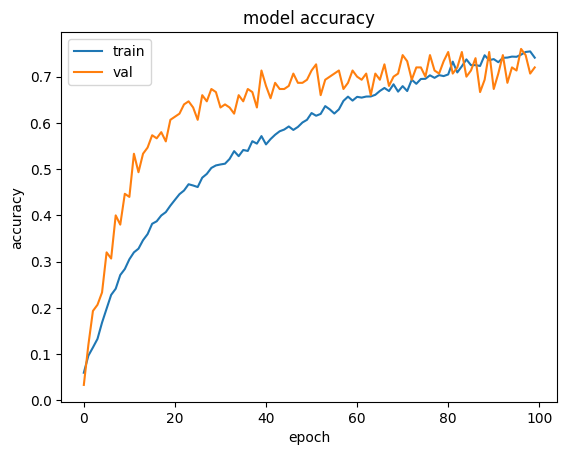

In [ ]:
# Trainingsverlauft mittels 'history' visualisieren
# Dargestellt werden die Trainings- und Validirerungs Accuracy über die Epochen
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Analyse des Modells


Hier erstellen wir eine Funktion, die uns dabei hilft, die Genauigkeit von verschiedenen Modellen über mehrere Trainingsepochen hinweg zu visualisieren. Zunächst haben wir eine Funktion namens `create_model_dataframe`, die speziell dafür entwickelt wurde, einen DataFrame für ein bestimmtes Modell basierend auf seiner Genauigkeit über die Epochen zu erstellen. Danach nutzen wir die Funktion `plot_multiple_models`, die mehrere dieser DataFrames nimmt und sie in einem gemeinsamen Liniendiagramm darstellt. Dies ermöglicht es uns, die Leistung verschiedener Modelle im Laufe der Zeit direkt miteinander zu vergleichen. Zum Schluss werden wir ein Beispiel sehen, in dem die Genauigkeits- und Validierungsgenauigkeitswerte eines Modells über verschiedene Epochen hinweg geplottet werden.

In [ ]:

#als Funktion geschrieben, um es leichter wiederverwendbar zu machen

#Funktion to create a DataFrame for a specific model
def create_model_dataframe(  accuracy, model_name):
    data = {
        f'Epochs_{model_name}': np.arange(0, len(accuracy) ),
        f'Accuracy_{model_name}': accuracy
    }
    df_model = pd.DataFrame(data, columns=[f'Epochs_{model_name}', f'Accuracy_{model_name}'])
    return df_model

# Function to create and plot line charts for multiple models
def plot_multiple_models( accuracy_list, model_name_list):
    plt.figure(figsize=(10, 6))
    sns.set(style="darkgrid")



    for  accuracy, model_name_a in zip( accuracy_list, model_name_list):
        df_model = create_model_dataframe( accuracy, model_name_a)
        df_model = df_model.reindex(epochs).interpolate().fillna(method='ffill')
        sns.lineplot(data=df_model, x=f'Epochs_{model_name_a}', y=f'Accuracy_{model_name_a}', label=model_name_a, marker='o')

    # Add title and axis labels
    plt.title('Accuracy vs. Epochs for Multiple Models')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    # Show the legend
    plt.legend(title='Model')

    # Show the plot
    plt.show()

# Example usage

model_names = ['accuracy', 'val_accuracy']
 #
plot_multiple_models(  [history.history['accuracy'], history.history['val_accuracy']], model_names)




# ResNet

Hier brauchen wir noch einen kleinen Text.
Oder kommt hier der Use Case auf ResNet angewendet

*Referenzen:*

https://arxiv.org/pdf/1512.03385.pdf



## ResNet Theorie

Residual Networks, kurz ResNet genannt, sind eine spezielle Art von neuronalen Netzwerken, die 2015 von Kaiming He et al. eingeführt wurden. ResNets wurden entwickelt, um das Problem des Verschwindens von Gradienten bei sehr tiefen neuronalen Netzwerken zu überwinden. Ihr grundlegendes Konzept besteht darin, Schicht-überspringende Verbindungen in die Architektur zu integrieren.

Im Wesentlichen modellieren ResNets die Netzwerkfunktion als die Residualfunktion eines Blocks. Anstatt die Ausgabe einer Schicht einfach zur nächsten Schicht zu leiten, wird sie zur ursprünglichen Eingabe addiert. Dies ermöglicht es, dass die Netzwerkaktivierung und der Gradient effizienter durch das Netzwerk fließen können. Das bedeutet, dass selbst sehr tiefe Netze, die aus Hunderten von Schichten bestehen, problemlos trainiert werden können, ohne dass Gradienten verschwinden.

Die Vorzüge von ResNets sind signifikant. Sie erlauben das Training von Netzwerken mit Hunderten von Schichten ohne das Problem des Verschwindens von Gradienten. Dies hat zu bahnbrechenden Ergebnissen in verschiedenen Computer-Vision-Aufgaben geführt, darunter Bildklassifizierung und Objekterkennung.

ResNet 50 ist ein spezifisches Modell der ResNet-Familie und zeichnet sich durch eine hohe Tiefe aus. Das Modell besteht aus insgesamt 50 Schichten oder Blöcken. Jeder dieser Blöcke setzt sich aus einer Abfolge von Convolutional-Schichten zusammen und beinhaltet eine Shortcut-Verbindung. Ein Konzept des ResNet50 ist das "Deep Residual Learning". Hierbei werden Residualfunktionen innerhalb der Blöcke erlernt, um die Gesamtleistung des Netzwerks zu steigern. Diese Methode trägt entscheidend zur Trainingsstabilität und zur besseren Anpassungsfähigkeit des Modells bei. Das ResNet50 Modell hat eine breite Anwendungsgrundlage und findet insbesondere in Bildklassifizierungs-, Objekterkennungs- und Segmentierungsaufgaben Anwendung. Die Praxis hat gezeigt, dass dieses Modell in diesen Domänen eine erstklassige Leistung erzielt. Die wissenschaftliche Bedeutung von ResNet50 und seiner zugrunde liegenden Prinzipien ist in zahlreichen Wettbewerben und Anwendungsbereichen offenkundig geworden und unterstreicht die zentrale Rolle dieses Modells in der modernen tiefen Bildverarbeitung.

## Datensatz

Das ResNet50-Modell wurde erstmals im Rahmen der „ImageNet Large Scale Visual Recognition Challenge 2015“ angewendet. In diesem Wettbewerb arbeiten viele verschiedene Teams daran ein möglichst perfektes Modell zur Bildklassifizierung auf Basis des ImageNet-Datensatz zu entwickeln.

Der ImageNet-Datensatz ist eine bedeutende Ressource in der Domäne des maschinellen Lernens und der Computer Vision. Mit Millionen von Bildern und einer umfassenden Klassifikation in mehrere tausend Kategorien zählt er zu den größten und am weitesten verbreiteten Datensätzen für Bilderkennungsaufgaben. Der ImageNet-Datensatz umfasst dabei eine breite Palette von Kategorien, die von Tieren und Pflanzen über Alltagsgegenstände bis hin zu abstrakten Konzepten reichen. Dies ermöglicht es, Modelle auf eine breite Palette von visuellen Konzepten zu trainieren und deren allgemeine Performance zu testen.

## ResNet 50 Architektur




ResNet steht für Residual Network. ResNet ist eine spezielle Form der neuronalen Netze welche 2015 im Paper „Deep Residual Learning for Image Recognition“ von Kaiming He, Xiangyu Zhang, Shaoqing Ren and Jian Sun vorgestellt wurde. Ziel ihrer Arbeit war es das Training von tieferen neuronalen Netzen zu vereinfachen. Die Besonderheit des Resnet Architektur besteht in den entwickelten „residual Blocks“, welche den Input des vorherigen Layers mit dem Output des aktuellen Layers verbindet.
Mathematisch kann man sich dies wie folgt vorstellen:
Sei x der Output eines vorherigen Layers dann stellt F(x) eine Funktion dar, welche im aktuellen Layer x verwendet, um zu trainieren. Bevor die Ergebnisse F(x) in den nächsten Layer gegeben werden wird F(x) mit +x erweitert, wobei x immer noch die Ergebnisse eines vorherigen Layers definiert.
(https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf)


Die im folgenden genutzte Architektur ist ResNet 50. Die Zahl definiert hierbei die Anzahl der genutzten Layer. Auch wenn ResNet 152 im Paper ursprünglich als die beste Architektur herausgestellt wurde, wir häufig auf Resnet 50 zurückgegriffen. ResNet 50 ist nicht signifikant schlechter, aber deutlich performanter als ResNet 152 im Bezug auf Trainingszeiten (https://arxiv.org/pdf/2002.08991.pdf#:~:text=The%20best%20classifications%20of%20pulmonary,ResNet%2D50%20(0.590).)

Die ResNet 50 Architektur bildet sich klassischerweise wie folgt:
1 Konvolution Layer mit einer Kernelgröße von 7*7 aus 64 verschiedenen Kerneln mit einer stride von 2.
9 Max-Pooling Layer welche aus einem sich dreimal wiederholenden Block besteht aus: 64 Kernel mit einer Größe von 1*1, 64 Kernel mit einer Größe von 3*3 sowie 256 Kernel wieder mit einer Größe von 1*1.
12 Layer die sich aus einem sich viermal wiederholenden Block aus folgenden Layern bildet: einem 128 Kernel großen Layer mit einer Größe von 1*1, gefolgt von einem weiteren 128 Kernel großen Layer diesmal mit einer 3*3 Größe und einem 512 Kernel großen Layer welcher wieder die Größe von 1*1 nutzt.
18 Layer die sich aus folgenden drei Layern, welche sechsmal wiederholt werden, zusammensetzt: eine 1*1 Größe bei 256 Kerneln, 256 Kernel bei einer Größe von 3*3 sowie 1024 Kernel bei einer Größe von 1*1.
9 weitere Layer folgen in einem dreier Block von 512 Kernel bei einer 1*1 Größe, 512 Kernel bei einer Größe von 3*3 sowie 2048 Kernel bei einer Größe von 1*1. Auch dieser Block wiederholt sich dreimal.
1 Layer welcher zum schluss einen average pool welcher mit einer fully connected Layer beendet wird. Diese enthält 1000 nodes (Knoten) und endet mit der Aktivierung der „Softmax“ funktion.

(https://iq.opengenus.org/resnet50-architecture/)


## Transfer Lernen mit ResNet


Da das ResNet Modell auf einem sehr großen Datensatz trainiert wurde, ist davon auszugehen, dass ResNet sehr gut gelehnt hat, strukturen zu erkennen. Um die Leistungsfähigkeit des ResNet Modells zu nutzen, kann das sogenannte Transfer Learning verwendet werden. Hierbei kann von der vortrainierten Architektur mitsamt ihren erlernten Gewichten profitiert werden.

Hierfür wird das Modell mit den Gewichten geladen. Dadurch wird die Fähigkeit des Modells, verschiedene Strukturen zu erkennen erhalten. Um diese während des Trainingsprozesses nicht zu verändern, werden diese 'eingefroren'.

Die letzten, Fully-Connected Layer werden dabei exkludiert. Dies ist wichtig, um den Output an die neuen Anforderungen anzupassen. Für dieses Projekt werden die Output Neuronen von 1000 auf 30 verändert, um die 30 verschiedenen Instrumente klassifizieren zu können.




Referenzen:

https://keras.io/api/applications/resnet/#resnet50-function

https://keras.io/api/applications/#usage-examples-for-image-classification-models

https://keras.io/guides/transfer_learning/

https://www.tensorflow.org/tutorials/images/transfer_learning

In [ ]:
# ResNet50 Modell mit den orgiginalen Gewichten laden
# Die Fully-Connected Layers werden nicht mit geladen.
ResNet_model = ResNet50(weights='imagenet', input_shape = (100,100,3), include_top = False)

94765736/94765736 [==============================] - 3s 0us/step


In [ ]:
# Modell Einfrieren
ResNet_model.trainable = False

In [ ]:
# Architektur des kombinierten Modells erstellen
combined_model = tf.keras.models.Sequential()

# In Anlehnung an die beste, neu geschaffene Architektur
# werden dieselben Augmentations Layer inkludiert.
combined_model.add(tf.keras.layers.RandomFlip("horizontal"))
combined_model.add(tf.keras.layers.RandomRotation(0.2)),
combined_model.add(tf.keras.layers.RandomZoom(0.1)),
combined_model.add(tf.keras.layers.RandomCrop(100,100)),

# ResNet Layer einfügen
combined_model.add(ResNet_model)

# Flatten und Output Layer einfügen
combined_model.add(tf.keras.layers.Flatten())
combined_model.add(tf.keras.layers.Dense(30, activation='softmax'))

In [ ]:
# Modell erstellen
combined_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [ ]:
# Modell trainieren und testen
# Die Ergebnisse werden in 'history' gespeichtert, um sie visualisieren zu können
history = combined_model.fit(
    one_hot_train_data,
    epochs=20,
    validation_data=one_hot_test_data,
)

Epoch 1/20
150/150 [==============================] - 23s 58ms/step - loss: 4.7919 - accuracy: 0.0835 - val_loss: 3.8119 - val_accuracy: 0.1467
Epoch 2/20
150/150 [==============================] - 6s 37ms/step - loss: 3.7319 - accuracy: 0.1262 - val_loss: 3.4949 - val_accuracy: 0.2400
Epoch 3/20
150/150 [==============================] - 6s 40ms/step - loss: 3.8608 - accuracy: 0.1398 - val_loss: 3.8050 - val_accuracy: 0.2533
Epoch 4/20
150/150 [==============================] - 6s 39ms/step - loss: 3.7286 - accuracy: 0.1550 - val_loss: 3.4560 - val_accuracy: 0.2467
Epoch 5/20
150/150 [==============================] - 7s 45ms/step - loss: 3.8241 - accuracy: 0.1665 - val_loss: 3.5034 - val_accuracy: 0.2867
Epoch 6/20
150/150 [==============================] - 6s 38ms/step - loss: 3.5783 - accuracy: 0.1784 - val_loss: 3.6929 - val_accuracy: 0.2467
Epoch 7/20
150/150 [==============================] - 7s 43ms/step - loss: 3.5702 - accuracy: 0.1853 - val_loss: 2.6258 - val_accuracy: 0.313

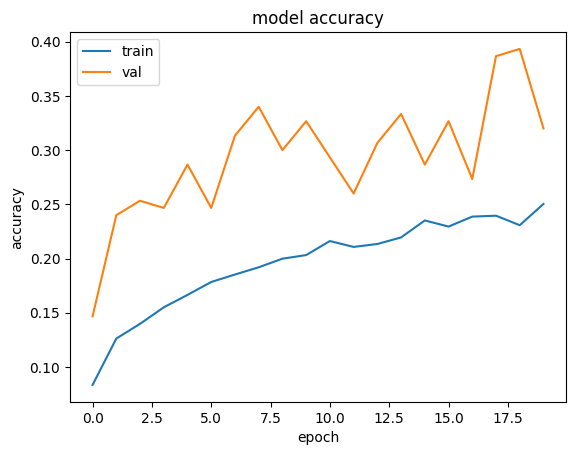

In [ ]:
# Trainingsverlauft mittels 'history' visualisieren
# Dargestellt werden die Trainings- und Validirerungs Accuracy über die Epochen
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## ResNet Fine-Tuning



Das Fine-Tuning ist eine Art des Transfer Lernens. Hier werden die Layer des vortrainierten Modells nicht eingefroren. Dies hat den Vorteil, dass das Modell besser auf die neuen Anforderungen angepasst werden kann. Um die Fähigkeiten des Modells, Strukturen zu erkennen, ideal nutzen zu können, ohne ein Overfitting zu riskieren, wird die Learning Rate eine sehr niedrige Lernrate verwendet.


*Referenzen:*

https://keras.io/guides/transfer_learning/

https://www.tensorflow.org/tutorials/images/transfer_learning

In [ ]:
# ResNet Modell entfrieren
ResNet_model.trainable = True

In [ ]:
# Architektur des kombinierten Modells erstellen

fine_tuned_model = tf.keras.models.Sequential()

# In Anlehnung an die beste, neu geschaffene Architektur
# werden dieselben Augmentations Layer inkludiert.
fine_tuned_model.add(tf.keras.layers.RandomFlip("horizontal"))
fine_tuned_model.add(tf.keras.layers.RandomRotation(0.2)),
fine_tuned_model.add(tf.keras.layers.RandomZoom(0.1)),
fine_tuned_model.add(tf.keras.layers.RandomCrop(100,100)),

# ResNet Layer einfügen
fine_tuned_model.add(ResNet_model)

# Flatten und Output Layer einfügen
fine_tuned_model.add(tf.keras.layers.Flatten())
fine_tuned_model.add(tf.keras.layers.Dense(30, activation='softmax'))

Epoch 1/30
150/150 [==============================] - 62s 127ms/step - loss: 5.0713 - accuracy: 0.0371 - val_loss: 14.5454 - val_accuracy: 0.0467
Epoch 2/30
150/150 [==============================] - 16s 107ms/step - loss: 5.0766 - accuracy: 0.0342 - val_loss: 25.9180 - val_accuracy: 0.0267
Epoch 3/30
150/150 [==============================] - 16s 107ms/step - loss: 5.1002 - accuracy: 0.0315 - val_loss: 13.8797 - val_accuracy: 0.0400
Epoch 4/30
150/150 [==============================] - 16s 108ms/step - loss: 5.1321 - accuracy: 0.0313 - val_loss: 7.0938 - val_accuracy: 0.0200
Epoch 5/30
150/150 [==============================] - 17s 109ms/step - loss: 5.1062 - accuracy: 0.0373 - val_loss: 5.1951 - val_accuracy: 0.0200
Epoch 6/30
150/150 [==============================] - 17s 110ms/step - loss: 5.1070 - accuracy: 0.0369 - val_loss: 5.0025 - val_accuracy: 0.0533
Epoch 7/30
150/150 [==============================] - 16s 108ms/step - loss: 5.0854 - accuracy: 0.0344 - val_loss: 5.2896 - val

In [ ]:
# Modell erstellen
fine_tuned_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-10),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [ ]:
# Modell trainieren und testen
# Die Ergebnisse werden in 'history' gespeichtert, um sie visualisieren zu können
history_fine_tuned = fine_tuned_model.fit(
    one_hot_train_data,
    epochs=30,
    validation_data=one_hot_test_data,
)

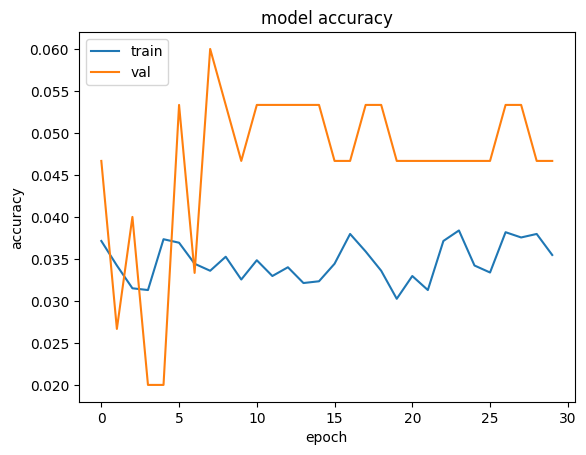

In [ ]:
# Trainingsverlauft mittels 'history' visualisieren
# Dargestellt werden die Trainings- und Validirerungs Accuracy über die Epochen
plt.plot(history_fine_tuned.history['accuracy'])
plt.plot(history_fine_tuned.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()